In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Reading the CSV file and storing the values.

In [3]:
length_list = []
T_data = []

with open('pendulum_experiment_2.csv', 'r', newline='') as f:
    reader = csv.reader(f)
    header = next(reader)  # skip the header row
    
    for row in reader:
        length = float(row[0])
        T_measurements = list(map(float, row[6:11]))   # convert T1..T5 to floats
        
        length_list.append(length)
        T_data.append(T_measurements)
        
length_array = np.array(length_list)
T_data = np.array(T_data)  # shape (N, 5) if you have N lengths

    

### Debug Log
```
---------------------------------------------------------------------------
UFuncTypeError                            Traceback (most recent call last)
Cell In[152], line 2
      1 # Method A: Fit using averaged data (5 points)
----> 2 mean_periods = np.mean(T_data, axis=1)  # average over columns (5 repeated T's)
      3 std_periods  = np.std(T_data, axis=1, ddof=1)  # sample std dev for each row
      5 # Fit these 5 data points

File c:\Users\windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504, in mean(a, axis, dtype, out, keepdims, where)
   3501     else:
   3502         return mean(axis=axis, dtype=dtype, out=out, **kwargs)
-> 3504 return _methods._mean(a, axis=axis, dtype=dtype,
   3505                       out=out, **kwargs)

File c:\Users\windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:118, in _mean(a, axis, dtype, out, keepdims, where)
    115         dtype = mu.dtype('f4')
    116         is_float16_result = True
--> 118 ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
    119 if isinstance(ret, mu.ndarray):
    120     with _no_nep50_warning():

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None

```
`T_measurements = list(row[6:11])` is changed to `T_measurements = list(map(float, row[6:11]))` : If you don’t use map, the items in row[6:11] will remain as strings. This can lead to issues later if you try to perform numerical operations on these values, since arithmetic with strings will result in errors.


 

# Base Model : 

For Simple Pendulum:
$$
T = 2\pi \sqrt{\frac{L}{g}}
$$

T : Period

L : length of pendulum

g : acceleration due to gravity

In [4]:
def pendulum_period(L, g): 
    return 2.0 * np.pi * np.sqrt(L / g) # period of a simple pendulum

# Method A : Fitting Using Average Data

In [5]:
# Method A: Fit using averaged data (5 points)
mean_periods = np.mean(T_data, axis=1)  # average over columns (5 repeated T's)
std_periods  = np.std(T_data, axis=1, ddof=1)  # sample std dev for each row

# Fit these 5 data points
poptA, pcovA = curve_fit(
    pendulum_period,
    length_array,
    mean_periods,               # initial guess for g
    sigma=std_periods,      # use the std dev as the error
    absolute_sigma=True      # treat these errors as absolute
)

g_fitA = poptA[0] # fitted g value
g_errA = np.sqrt(np.diag(pcovA))[0] # error in g

print("=== Method A: Fit using averaged data (5 points) ===")
print(f"Estimated g = {g_fitA:.4f} ± {g_errA:.4f} m/s^2\n") 

=== Method A: Fit using averaged data (5 points) ===
Estimated g = 9.8505 ± 0.0487 m/s^2



# Method B : Using All 25 Data Points Individually

In [6]:
#METHOD B: USE ALL 25 DATA POINTS INDIVIDUALLY
num_measurements = T_data.shape[1]  # number of T measurements per length
all_lengths = np.repeat(length_array, num_measurements) # repeat each length 5 times
all_periods = T_data.flatten() # flatten the 2D array to 1D
all_sigmas  = np.repeat(std_periods, num_measurements) # repeat the std dev for each length


# Now fit 25 points
poptB, pcovB = curve_fit(
    pendulum_period,
    all_lengths,
    all_periods,
    sigma=all_sigmas,
    absolute_sigma=True
)

g_fitB = poptB[0] # fitted g value
g_errB = np.sqrt(np.diag(pcovB))[0] # error in g

print("=== Method B: Fit using all data points (25 points) ===")
print(f"Estimated g = {g_fitB:.4f} ± {g_errB:.4f} m/s^2\n")


=== Method B: Fit using all data points (25 points) ===
Estimated g = 9.8505 ± 0.0218 m/s^2



# Comparison of Method A and Method B

In [7]:
#COMPARE RESULTS
# ------------------------------------------------------
print("Comparison of results:")
print(f"Method A (5 points):  g = {g_fitA:.4f} ± {g_errA:.4f}")
print(f"Method B (25 points): g = {g_fitB:.4f} ± {g_errB:.4f}")

Comparison of results:
Method A (5 points):  g = 9.8505 ± 0.0487
Method B (25 points): g = 9.8505 ± 0.0218


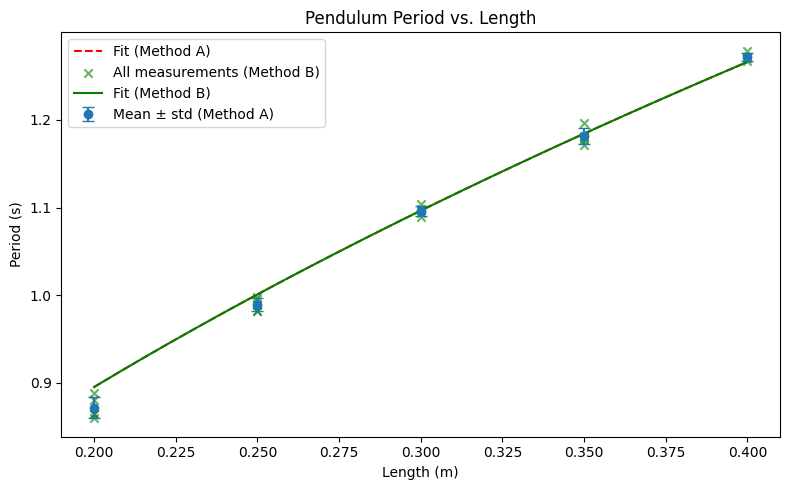

In [8]:
plt.figure(figsize=(8,5))

# Plot Method A data
plt.errorbar(
    length_array, mean_periods, yerr=std_periods,
    fmt='o', capsize=4, label='Mean ± std (Method A)'
)

# Overplot the fit curve for Method A
L_fit = np.linspace(min(length_array), max(length_array), 100)
T_fitA = pendulum_period(L_fit, g_fitA)
plt.plot(L_fit, T_fitA, 'r--', label='Fit (Method A)')

# Scatter all points from Method B (25 total) for visualization
plt.scatter(
    all_lengths, all_periods, marker='x', color='green',
    alpha=0.6, label='All measurements (Method B)'
)

# Overplot the fit curve for Method B
T_fitB = pendulum_period(L_fit, g_fitB)
plt.plot(L_fit, T_fitB, 'g-', label='Fit (Method B)')

plt.xlabel('Length (m)')
plt.ylabel('Period (s)')
plt.title('Pendulum Period vs. Length')
plt.legend()
plt.tight_layout()
plt.show()

### Results 
```
Comparison of results:
Method A (5 points):  g = 9.8505 ± 0.0487
Method B (25 points): g = 9.8505 ± 0.0218
```
![Pendulum Period vs Length](./pictures/Pendulum_Period_vs_Length.png)

### Result Explanation
As we can see the comparison of the average fitting (method A) and the fitting of all 25 data points (method B), using method B has less errors when it comes to calculation acceleration due to gravity. For this case, using the all the different data points is more reliable than using the average data points since the dataset is quite small and using the average can lose some important information such as the outliers and noise.

### Conclusion
For this week we learnt that using all the data points is more reliable than using the average data points. We also learnt how to use NumPy's `mean` and `std` functions to calculate the mean and standard deviation of the data points. And something important when using `std` is the delta degree of freedom (ddof) should be set to 1 instead of using the default 0 because we are working with a sample data not the whole population.